Image recognition of Anderson states in 3D

This notebook has four main sections:

*   Preliminaries
  *   Run this at the start to initialize and import many important variables, parameters and libraries. This includes a cell which requires you to authorise the use of a google drive which you will be sent a code to verify the use of.
  *   The google drive must be formatted as follows:
      *   MyDrive
          *    code
          *    csvdata
          *    ModelStages
  *   This format can be tweaked within the code but it ijs likely to cause errors! (see code for more specific guidance on what to call folder and files etc)

*   Functions and main methods
  *    Cells which contain functions that do all kinds of jobs from loading the data in from folders to optimising hyperparameters
*   Result Gathering
  *    Create sub-cells called ***TEST x - description of the test*** then code in a test using the code from the rest of the program. Running only when using the cell to test again ensures that all tests stay in the notebook until it is cleared (as well as many results being saved automatically anyway)
*   Interpretation
    *     Confusion matrix for a given epoch that is saved in the google drive





## Preliminaries

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

Checking for GPU

In [2]:
#import tensorflow as tf
#from tensorflow.python.client import device_lib

#print(tf.test.gpu_device_name())
#print(device_lib.list_local_devices())

#!cat /proc/meminfo

Checking for TPU

In [3]:
import os
assert os.environ['COLAB_TPU_ADDR']
Path = 'grpc://'+os.environ['COLAB_TPU_ADDR']
print('TPU Address:', Path)

TPU Address: grpc://10.86.129.130:8470


In [4]:
import torch
import torch.nn
torch.__version__
from torch.utils.data import Dataset, DataLoader
#from torchvision import transforms, utils
#!pip install torch=='1.7.0'
#!pip install torchvision=='0.8.1'
import torch
import torchvision
print(torchvision.__version__)
print(torch.__version__)

0.8.1+cu101
1.7.0+cu101


In [5]:
import random
import math

In [6]:
#!pip install fastai==1.0.61
import fastai
from fastai.collab import *
#!pip install --upgrade fastai
#!pip uninstall fastai -y
print(fastai.__version__)
from fastai.vision import *


1.0.61


In [7]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


###Parameters and variables



In [8]:
global loaded_training
global loaded_validation
global loaded_testing
global loaded_labels
loaded_training   = {}
loaded_validation = {}
loaded_testing    = {}
loaded_labels     = {}

d_type_opt = ('training', 'validation')

bs = 40
epoch_chunk = 3
t_f_default = 0.7
v_f_default = 0.2
global training_fraction
global validation_fraction
training_fraction   = t_f_default
validation_fraction = v_f_default

#Functions and main methods

## Generic Functions


In [9]:
def get_files(folder):
  dir = '/content/drive/MyDrive/csvdata/'+folder+'/'
  N = 1    #Desired number of input systems per class
  files = !ls -l {dir}
  print(files)
  files.reverse()
  files.pop()
  for i in range(len(files)):
    files[i] = files[i].rsplit(' ',1)[1]
    print(files[i])
  return dir,files

In [10]:
def to_list(list):
  py_list = []
  for i in list:
    py_list.append(float(i))
  return py_list

In [11]:
def make_3D_structure(file, system_size):
    col = 0
    row = 0
    lay = 0
    
    real_3d_with_channel_system = []
    system = []
    for i in range(system_size):
        system.append([])
        for j in range(system_size):
            system[-1].append([])
            for j in range(system_size):
                system[-1][-1].append([])
    #print(len(system))
    #print(len(system[0]))
    #print(len(system[0][0]))
    
    for line in file:
        if col == system_size:
            col = 0
            row += 1
        if row == system_size:
            row = 0
            lay += 1
        system[col][row][lay] = float(line)
        #print(float(line))
        col += 1
    real_3d_with_channel_system.append(system)
    return system

##Object definitions

**Definition of our custom Dataset and label_list class for confusion matrix**

In [12]:
class label_list():
  def __init__(self, data, label_names):
    self.classes = label_names
    self.items = data
  def get(self,i):
    return self.items[i]
  def len(self):
    return len(self.classes)
        

In [13]:
class ThreeDDataset(Dataset):
    def __init__(self, x, y):
        self.x = []
        self.y = []
        class_ind = 0
        for dis_class in x:
          for item in dis_class:
            self.x.append(item)
            self.y.append(class_ind)
          class_ind+=1
        
        def seed():
          return 0.1234

        random.shuffle(self.x, seed)
        random.shuffle(self.y, seed)

        self.y = label_list(self.y, y)
        #print("data: ", len(self.x))
        #print("labels: ", self.y.len(), self.y.items)
        
        self.c = len(self.y.classes)

        t = True
        for dis_class in x:
          t = (t and len(dis_class)==0)
        self.is_empty=t
    
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, i):
        return self.x[i],self.y.get(i)

**Definition of our custom Neural Network Model (not yet in use) **

In [14]:
class NNet(nn.Module):
    def __init__(self, num_classes=17):
        super(NNet, self).__init__()
        self.layers = nn.Sequential(
          nn.Conv2d(20,64,5),
          nn.ReLU(),
          nn.Conv2d(64,64,5),
          nn.ReLU()
        )

    def forward(self, x):
        out = self.layers(x)
        return out
print(NNet)


<class '__main__.NNet'>


##Load data from folders

In [15]:
import pandas as pd
import io

def prepare_datasets(folder,d_type,seed, batch_size=1, binning=False,bin_size=1, skip_amount=0, extr=False):
  if extr:
    binning = False
    skip_amount = 0
    
  folder = folder + d_type + '_' + 'seed' + seed
  loaded = False
  class_skipping = (skip_amount>0)

  loaded = False
  if str(folder) in loaded_training.keys():
    print("Found pre-loaded data " + folder)
    tensors_training   = loaded_training[str(folder)]
    tensors_validation = loaded_validation[str(folder)]
    tensors_testing    = loaded_testing[str(folder)]
    labels             = loaded_labels[str(folder)]
    loaded = True

  if not loaded:
    if d_type=='validation':
      training_fraction  =0.1
      validation_fraction=0.99
    elif d_type=='training':
      training_fraction  =t_f_default
      validation_fraction=v_f_default

    dir = '/content/drive/MyDrive/csvdata/'+folder+'/'
    print("   Data directory: ", dir)
    files = !ls -l {dir}
    files.reverse()
    files.pop()
    for i in range(len(files)):
      files[i] = files[i].rsplit(' ',1)[1]
    tensors_training   = []  #Each list in this list is a seperate label list
    tensors_validation = []  #
    tensors_testing    = []  #
    global n_labels
    n_labels = len(files)    #Defined by the number of data csv files
    print("Number of classes: ", n_labels)

    labels = []
    class_val = 0
    for class_file in files:
      """
      Add new class to the tensors list, read the systems one by one out 
      of the data file then add that data to the correct class list in tensors
      and add the name of the disorder class to the labels list   
      """
      tensors_training.append([])
      tensors_validation.append([])
      tensors_testing.append([])
      print(class_file)
      disorder_class = class_file.rsplit('-',1)[0]
      disorder_class = disorder_class.rsplit('W',1)[1]
      labels.append(disorder_class)

      with open(dir+class_file, 'r') as f:
        df = pd.read_csv(f)

      for i in range(len(df.transpose())-1):         
        """
        Go through each system and add them to the data
        """           
        ThreeD_array = make_3D_structure(to_list(df[str(i)]),20)
        system = torch.tensor(ThreeD_array)

        ran_numb = random.random()
        if ran_numb >= 1 - training_fraction:
          tensors_training[-1].append(system)
        
        elif ran_numb < validation_fraction:
          tensors_validation[-1].append(system)
        
        else:
          tensors_testing[-1].append(system)
      class_val+=1
    #print(labels)

    if str(folder) not in loaded_training.keys():   #Saving the models in a global dictionary for faster loading later
      print("No pre-existing data " + folder + ". Saving in dictionary")
      loaded_training[str(folder)]   = tensors_training
      loaded_validation[str(folder)] = tensors_validation
      loaded_testing[str(folder)]    = tensors_testing
      loaded_labels[str(folder)]     = labels


    
  if class_skipping:    #Skipping every 'skip_amount' classes
    new_labels = []
    for i in range(len(labels)):
      if i*(skip_amount+1) > len(labels)-1:
        break
      new_labels.append(labels[i*(skip_amount+1)])
    labels = new_labels
    print("After skipping: ", labels)

    new_tensors_training = []
    for i in range(len(tensors_training)):
      if i*(skip_amount+1) > len(tensors_training)-1:
        break
      new_tensors_training.append(tensors_training[i*(skip_amount+1)])
    tensors_training = new_tensors_training

    new_tensors_validation = []
    for i in range(len(tensors_validation)):
      if i*(skip_amount+1) > len(tensors_validation)-1:
        break
      new_tensors_validation.append(tensors_validation[i*(skip_amount+1)])
    tensors_validation = new_tensors_validation

    new_tensors_testing = []
    for i in range(len(tensors_testing)):
      if i*(skip_amount+1) > len(tensors_testing)-1:
        break
      new_tensors_testing.append(tensors_testing[i*(skip_amount+1)])
    tensors_testing = new_tensors_testing

  if binning:        #Bin each of the datasets
    print("")
    print("")
    print("")
    print("----")
    print("   Binning data")
    binned_labels = []
    binned_tensors_training = []
    binned_tensors_validation = []
    binned_tensors_testing = []

    binned_labels.append([])   
    binned_tensors_training.append([])
    binned_tensors_validation.append([])
    binned_tensors_testing.append([])

    print(len(labels)) 
    for i in range(len(labels)):       
      for label in labels[i]:
        binned_labels[-1].append(label)
      if (i+1)%bin_size == 0:
        binned_labels.append([])
    if len(labels)%bin_size != 0:
      del binned_labels[-1]
    print("total bins (la): ", len(binned_labels))
    labels = binned_labels
    n_labels = len(labels)
    print(len(labels))

    print(len(tensors_training)) 
    for i in range(len(tensors_training)):       
      for tensor in tensors_training[i]:
        binned_tensors_training[-1].append(tensor)
      if (i+1)%bin_size == 0:
        binned_tensors_training.append([])
    if len(tensors_training)%bin_size != 0:
      del binned_tensors_training[-1]
    print("total bins (tr): ", len(binned_tensors_training))
    tensors_training = binned_tensors_training

    print(len(tensors_validation))
    for i in range(len(tensors_validation)):
      for tensor in tensors_validation[i]:
        binned_tensors_validation[-1].append(tensor)
      if (i+1)%bin_size == 0:
        binned_tensors_validation.append([])
    if len(tensors_validation)%bin_size != 0:
      del binned_tensors_validation[-1]
    print("total bins (va): ", len(binned_tensors_validation))
    tensors_validation = binned_tensors_validation

    print(len(tensors_testing))
    for i in range(len(tensors_testing)):
      for tensor in tensors_testing[i]:
        binned_tensors_testing[-1].append(tensor)
      if (i+1)%bin_size == 0:
        binned_tensors_testing.append([])
    if len(tensors_testing)%bin_size != 0:
      del binned_tensors_testing[-1]
    print("total bins (te): ", len(binned_tensors_testing))
    tensors_testing = binned_tensors_testing
    print("----")
    print("")
    print("")
    print("")



  
  if extr:   #Take only the most extreme classes from the data
    t_labels = []
    t_labels.append(labels[0])
    t_labels.append(labels[-1])
    labels = t_labels

    t_tensors_training = []
    t_tensors_training.append(tensors_training[0])
    t_tensors_training.append(tensors_training[-1])
    tensors_training = t_tensors_training

    t_tensors_validation = []
    t_tensors_validation.append(tensors_validation[0])
    t_tensors_validation.append(tensors_validation[-1])
    tensors_validation = t_tensors_validation

    t_tensors_testing = []
    t_tensors_testing.append(tensors_testing[0])
    t_tensors_testing.append(tensors_testing[-1])
    tensors_testing = t_tensors_testing

    print("")
    print("")
    print("")
    print("----")
    print("   Taking only the extreme classes")
    print("len labels:     ", len(labels))
    print("len training:   ", len(tensors_training))
    print("len validation: ", len(tensors_validation))
    print("len testing:    ", len(tensors_testing))
    print("labels =        ", labels)
    print("----")
    print("")
    print("")
    print("")
  

  loader_training = ThreeDDataset(tensors_training, labels)
  loader_validation = ThreeDDataset(tensors_validation, labels)
  loader_testing = ThreeDDataset(tensors_testing, labels)
  databunch = DataBunch.create(loader_training, loader_validation, loader_testing, bs=bs, num_workers=0)

  return databunch

##Create CnnLearner

In [16]:
def create_learner(folder,d_type,seed, show_model=False, batch_size=1, binning=False,bin_size=1, skip_amount=0, opt=optim.Adam, save=True, extr=False):
  databunch = prepare_datasets(folder, d_type, seed, binning=binning, batch_size=batch_size, bin_size=bin_size, skip_amount=skip_amount, extr=extr)
  global learn 
  learn = cnn_learner(databunch, models.resnet18, metrics=[accuracy], loss_func=torch.nn.CrossEntropyLoss(), opt_func=opt, pretrained=False)
  global c_model
  c_model = 'resnet18-'      #Model
  metric = 'metric=error_rate-'     #Metric
  loss = 'loss=CrossEntropyLoss-' #Loss 
  optimizer = 'opt=ADAM-'
  twod_or_threed = 'CONV2D-'
  c_model = twod_or_threed+c_model+metric+loss+optimizer

  learn.model[0][0] = nn.Conv2d(20, 64, kernel_size=(3, 3), stride=(1, 1), padding=(0, 0), bias=False)
  learn.model[1][8] = nn.Linear(in_features=512, out_features=n_labels, bias=True)
  
  if show_model:
    learn.summary()

  if d_type=='training' and save:
    learn.lr_find(start_lr=1e-4, end_lr=10, num_it=100, stop_div=False)
    learn.recorder.plot()
    learn.recorder.plot_lr()

  if save:
    c_model_t = c_model +'bs='+str(learn.recorder.train_dl.batch_size)+'-ntrain='+folder+d_type+'_'+seed#str(learn.recorder.train_dl.dl.dataset.__len__())
    !mkdir /content/drive/MyDrive/ModelStages/{c_model_t}
    learn.save('/content/drive/MyDrive/ModelStages/'
                                +c_model
                                +'bs='+str(learn.recorder.train_dl.batch_size)
                                +'-ntrain='+folder+d_type+'_'+seed #str(learn.recorder.train_dl.dl.dataset.__len__())
                                +'/epochs-0')

##Create Custom Learner

In [17]:
def create_custom_learner(folder,d_type,seed, show_model=False, batch_size=1, binning=False,bin_size=1, skip_amount=0, opt=optim.Adam, save=True):
  databunch = prepare_datasets(folder, d_type, seed, binning=binning, batch_size=batch_size, bin_size=bin_size, skip_amount=skip_amount)
  global learn 
  learn = Learner(databunch, NNet, metrics=[accuracy], loss_func=torch.nn.CrossEntropyLoss(), opt_func=opt, pretrained=False)
  global c_model
  c_model = 'densenet121-'      #Model
  metric = 'metric=error_rate-'     #Metric
  loss = 'loss=CrossEntropyLoss-' #Loss 
  optimizer = 'opt=ADAM-'
  twod_or_threed = 'CONV2D-'
  c_model = twod_or_threed+c_model+metric+loss+optimizer

  learn.model[0][0] = nn.Conv2d(20, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(0, 0), bias=False)
  learn.model[1][8] = nn.Linear(in_features=512, out_features=n_labels, bias=True)
  
  if show_model:
    learn.summary()

  if d_type=='training' and save:
    learn.lr_find(start_lr=1e-4, end_lr=5, num_it=100, stop_div=False)
    learn.recorder.plot()
    learn.recorder.plot_lr()

  if save:
    c_model_t = c_model +'bs='+str(learn.recorder.train_dl.batch_size)+'-ntrain='+folder+d_type+'_'+seed#str(learn.recorder.train_dl.dl.dataset.__len__())
    !mkdir /content/drive/MyDrive/ModelStages/{c_model_t}
    learn.save('/content/drive/MyDrive/ModelStages/'
                                +c_model
                                +'bs='+str(learn.recorder.train_dl.batch_size)
                                +'-ntrain='+folder+d_type+'_'+seed #str(learn.recorder.train_dl.dl.dataset.__len__())
                                +'/epochs-0')

##Baysian Optimisation functions


In [18]:
def fit_with(lr, mom, wd):

  '''
  You can define your own fit_with() function that takes in the arguments you give to the 
  pbounds object (a dictionary whose keys are the names of the parameters and
  whose items are tuples containing the bounds for each parameter)
   and uses them to calculate an 'accuracy' that you then return.
  optimise_bayesian() then uses this function as a metric to give the optimal 
  values of the parameters you enter (in the ranges you specify in pbounds)
  '''

  folder = 'raw_data_transfering_200_'
  d_type = d_type_opt[0]
  seed = str(1111)
  batch_size = 120
  databunch = prepare_datasets(folder, d_type, seed, batch_size=batch_size, binning=True, bin_size=3, skip_amount=0)

  learn = cnn_learner(databunch, models.densenet121, metrics=[accuracy], loss_func=torch.nn.CrossEntropyLoss(), opt_func=optim.SGD, pretrained=False)
  learn.model[0][0] = nn.Conv2d(20, 1024, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  learn.model[1][8] = nn.Linear(in_features=512, out_features=n_labels, bias=True)

  learn.fit_one_cycle(1, max_lr=lr)
  learn.recorder.plot_losses()
  acc = float(learn.validate(learn.data.valid_dl)[1])

  print("Accuracy:" + str(acc*100))
  return acc

In [19]:
def optimise_bayesian(pbounds,fit_with):
  !pip install bayesian-optimization
  from bayes_opt import BayesianOptimization

  #pbounds = {'lr': (1e-3, 1e+1), 'mom':(0, 0.99), 'wd':(1e-4, 1)}

  optimizer = BayesianOptimization(
      f=fit_with,
      pbounds=pbounds,
      verbose=2, # verbose = 1 prints only when a maximum is observed, verbose = 0 is silent
      random_state=1,
  )   

  optimizer.maximize(init_points=2, n_iter=5)

  for i, res in enumerate(optimizer.res):
      print("Iteration {}: \n\t{}".format(i, res))

  print(optimizer.max)
  return optimizer.max

##Training Functions


In [20]:
def train_max_epochs(epoch_goal, lr=0.01, mom=0, weight_decay=0, epoch_chunk=5, save=True):
  n_epochs_total = 0
  #learn.unfreeze()
  validation_losses = []
  training_losses = []
  n_batches = len(learn.recorder.train_dl)
  while n_epochs_total < epoch_goal:
    n_epochs_total = load_latest_training(learn, c_model)
    print("Best training so far: ", n_epochs_total)

    learn.fit_one_cycle(epoch_chunk,max_lr=slice(1e-6,1e-4),moms=mom,wd=weight_decay)
    n_epochs_total += epoch_chunk

    print('/content/drive/MyDrive/ModelStages/'
      +c_model
      +'bs='+str(learn.recorder.train_dl.batch_size)
      +'-ntrain='+folder+d_type#str(learn.recorder.train_dl.dl.dataset.__len__())
      +'/epochs-'+str(n_epochs_total)
      +'-max_lr='+str(lr)
      +'-mom='+str(mom))

    if save:
      learn.save('/content/drive/MyDrive/ModelStages/'
      +c_model
      +'bs='+str(learn.recorder.train_dl.batch_size)
      +'-ntrain='+folder+d_type+'_'+seed #str(learn.recorder.train_dl.dl.dataset.__len__())
      +'/epochs-'+str(n_epochs_total)
      +'-max_lr='+str(lr)
      +'-mom='+str(mom))
    
    for c_val_loss in learn.recorder.val_losses:
      validation_losses.append(c_val_loss)
    for i in range(1,epoch_chunk+1):
      training_losses.append(learn.recorder.losses[i*n_batches-1].item())
    print("losses: ", training_losses)
    print("validation_losses: ", validation_losses)
  learn.recorder.plot_metrics()
  learn.recorder.plot_losses()
  return training_losses, validation_losses

In [21]:
def train_with_parameters(epochs_max,epoch_chunk=10, batch_size=30, opt=optim.Adam, mom=0, weight_decay=0, lr=0.1):
  folder = 'raw_data_transfering_4000_'
  d_type = d_type_opt[0]
  seed=str(1111)

  create_learner(folder,d_type,seed, batch_size=batch_size, binning=False,bin_size=1, skip_amount=0, opt=opt, save=True)
  training_losses,validation_losses = train_max_epochs(epochs_max,lr,mom,weight_decay, epoch_chunk,save=False)
  return training_losses,validation_losses

In [22]:
def load_latest_training(learn, c_model):
  dir = '/content/drive/MyDrive/ModelStages/'+c_model+'bs='+str(learn.recorder.train_dl.batch_size)+'-ntrain='+folder+d_type+'_'+seed+'/'
  training_files = !ls -l {dir}
  training_files.reverse()
  training_files.pop()

  for i in range(len(training_files)):
      training_files[i] = training_files[i].rsplit(' ',1)[1]
      training_files[i] = training_files[i].rsplit('.',1)[0]

  max_epoch_value = 0
  max_epoch_ind = -1
  if len(training_files)!=1:
    for i in range(len(training_files)-1):
      training_files[i] = training_files[i].rsplit('\'',1)[1]
      if int(training_files[i].rsplit('-',-1)[1].rsplit('-',-1)[0]) > max_epoch_value:
        max_epoch_value = int(training_files[i].rsplit('-',-1)[1].rsplit('-',-1)[0])
        max_epoch_ind = i
  else:
    max_epoch_ind = 0
  learn.load(dir+'/'+training_files[max_epoch_ind])
  
  
  return max_epoch_value

#Result Gathering

###Local Tests

In [23]:
local_tests = {}

####TEST Simple - Run this cell to train a network on some simple data

In [ ]:
    #TEST Simple - Run this cell to train a network on some simple data
folder   = 'raw_data_transfering_200_'
d_type   = d_type_opt[0]
seed     = str(1111)
sys_size = 20

create_learner(folder, d_type, seed, extr=True)
local_tests[str(c_model+'-max_e=100-'+'lr=1-'+'epoch_chunk=100-')] = [train_max_epochs(100,lr=1, epoch_chunk=100)]

####TEST 1 - Densenet121 4000 systems def hyperparameters

   Data directory:  /content/drive/MyDrive/csvdata/raw_data_transfering_4000_training_seed1111/
Number of classes:  17
W18.0-4000data_seed1111.csv
W17.75-4000data_seed1111.csv
W17.5-4000data_seed1111.csv
W17.25-4000data_seed1111.csv
W17.0-4000data_seed1111.csv
W16.8-4000data_seed1111.csv
W16.7-4000data_seed1111.csv
W16.6-4000data_seed1111.csv
W16.5-4000data_seed1111.csv
W16.4-4000data_seed1111.csv
W16.3-4000data_seed1111.csv
W16.2-4000data_seed1111.csv
W16.0-4000data_seed1111.csv
W15.75-4000data_seed1111.csv
W15.5-4000data_seed1111.csv
W15.25-4000data_seed1111.csv
W15.0-4000data_seed1111.csv
No pre-existing data raw_data_transfering_4000_training_seed1111. Saving in dictionary
['18.0', '17.75', '17.5', '17.25', '17.0', '16.8', '16.7', '16.6', '16.5', '16.4', '16.3', '16.2', '16.0', '15.75', '15.5', '15.25', '15.0']



----
   Taking only the extreme classes
len labels:      2
len training:    2
len validation:  2
len testing:     2
labels =         ['18.0', '15.0']
----





epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Best training so far:  0


epoch,train_loss,valid_loss,accuracy,time
0,2.825130,2.519966,0.352866,00:59
1,2.441033,2.205426,0.553503,00:59
2,2.216763,1.990909,0.637580,01:00
3,2.058016,1.859247,0.680255,00:59
4,1.931634,1.791680,0.703185,00:59
5,1.823080,1.737212,0.733121,00:59
6,1.817830,1.700183,0.750318,00:59
7,1.720053,1.658275,0.761146,01:00
8,1.704483,1.626734,0.766879,00:59
9,1.650427,1.606878,0.776433,01:08


epoch,train_loss,valid_loss,accuracy,time
0,2.825130,2.519966,0.352866,00:59
1,2.441033,2.205426,0.553503,00:59
2,2.216763,1.990909,0.637580,01:00
3,2.058016,1.859247,0.680255,00:59
4,1.931634,1.791680,0.703185,00:59
5,1.823080,1.737212,0.733121,00:59
6,1.817830,1.700183,0.750318,00:59
7,1.720053,1.658275,0.761146,01:00
8,1.704483,1.626734,0.766879,00:59
9,1.650427,1.606878,0.776433,01:08


/content/drive/MyDrive/ModelStages/CONV2D-densenet121-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=40-ntrain=raw_data_transfering_4000_training/epochs-100-max_lr=1-mom=0
losses:  [2.825129508972168, 2.441033124923706, 2.2167630195617676, 2.058015823364258, 1.931633710861206, 1.8230799436569214, 1.8178304433822632, 1.7200530767440796, 1.704483151435852, 1.6504273414611816, 1.5839580297470093, 1.5605323314666748, 1.5180165767669678, 1.5062955617904663, 1.4600483179092407, 1.4190311431884766, 1.3607779741287231, 1.3526841402053833, 1.2477176189422607, 1.2225147485733032, 1.203763723373413, 1.1735872030258179, 1.1619558334350586, 1.0993340015411377, 1.078810214996338, 1.026023268699646, 0.9981096386909485, 0.9434571266174316, 0.9051278233528137, 0.8587629199028015, 0.7960193753242493, 0.7683948278427124, 0.7732759118080139, 0.7269304394721985, 0.7135729789733887, 0.6773287653923035, 0.6431821584701538, 0.6127822995185852, 0.5946587324142456, 0.5605877041816711, 0.5348622798919678, 0

([2.825129508972168,
  2.441033124923706,
  2.2167630195617676,
  2.058015823364258,
  1.931633710861206,
  1.8230799436569214,
  1.8178304433822632,
  1.7200530767440796,
  1.704483151435852,
  1.6504273414611816,
  1.5839580297470093,
  1.5605323314666748,
  1.5180165767669678,
  1.5062955617904663,
  1.4600483179092407,
  1.4190311431884766,
  1.3607779741287231,
  1.3526841402053833,
  1.2477176189422607,
  1.2225147485733032,
  1.203763723373413,
  1.1735872030258179,
  1.1619558334350586,
  1.0993340015411377,
  1.078810214996338,
  1.026023268699646,
  0.9981096386909485,
  0.9434571266174316,
  0.9051278233528137,
  0.8587629199028015,
  0.7960193753242493,
  0.7683948278427124,
  0.7732759118080139,
  0.7269304394721985,
  0.7135729789733887,
  0.6773287653923035,
  0.6431821584701538,
  0.6127822995185852,
  0.5946587324142456,
  0.5605877041816711,
  0.5348622798919678,
  0.5138978362083435,
  0.49755752086639404,
  0.4757506251335144,
  0.4685657322406769,
  0.4690560996532

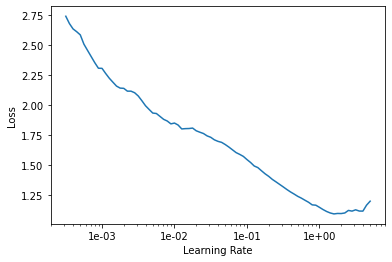

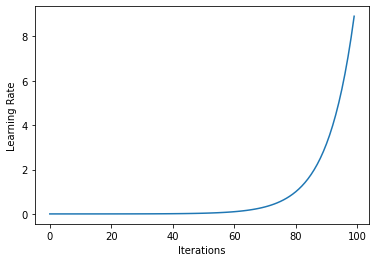

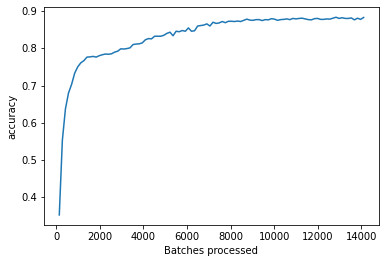

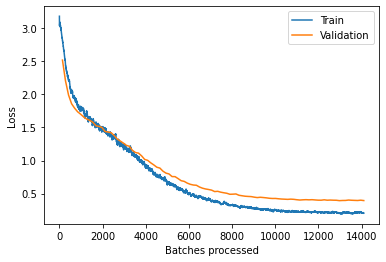

In [23]:
    #TEST 1 - Densenet121 4000 systems def hyperparameters
folder   = 'raw_data_transfering_4000_'
d_type   = d_type_opt[0]
seed     = str(1111)
sys_size = 20

create_learner(folder, d_type, seed, extr=True)
local_tests[str(c_model+'-max_e=100-'+'lr=1-'+'epoch_chunk=100-')] = [train_max_epochs(100,lr=1, epoch_chunk=100)]

####TEST 2 - Resnet18 4000 systems def hyperparameters

   Data directory:  /content/drive/MyDrive/csvdata/raw_data_transfering_4000_training_seed1111/
Number of classes:  17
W18.0-4000data_seed1111.csv
W17.75-4000data_seed1111.csv
W17.5-4000data_seed1111.csv
W17.25-4000data_seed1111.csv
W17.0-4000data_seed1111.csv
W16.8-4000data_seed1111.csv
W16.7-4000data_seed1111.csv
W16.6-4000data_seed1111.csv
W16.5-4000data_seed1111.csv
W16.4-4000data_seed1111.csv
W16.3-4000data_seed1111.csv
W16.2-4000data_seed1111.csv
W16.0-4000data_seed1111.csv
W15.75-4000data_seed1111.csv
W15.5-4000data_seed1111.csv
W15.25-4000data_seed1111.csv
W15.0-4000data_seed1111.csv
No pre-existing data raw_data_transfering_4000_training_seed1111. Saving in dictionary



----
   Taking only the extreme classes
len labels:      2
len training:    2
len validation:  2
len testing:     2
labels =         ['18.0', '15.0']
----





epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Best training so far:  0


epoch,train_loss,valid_loss,accuracy,time
0,3.123101,2.889730,0.077253,02:06
1,3.026970,2.768129,0.136113,02:05
2,2.895588,2.635172,0.248314,02:05
3,2.760612,2.478085,0.387492,02:05
4,2.620448,2.375193,0.468424,02:05
5,2.472199,2.217291,0.553648,02:05
6,2.300345,2.093724,0.599632,02:06
7,2.129650,1.947232,0.651134,02:05
8,1.952541,1.825456,0.686695,02:07
9,1.818223,1.680391,0.725322,02:05


/content/drive/MyDrive/ModelStages/CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=40-ntrain=raw_data_transfering_4000_training/epochs-100-max_lr=1-mom=0
losses:  [3.123100519180298, 3.0269696712493896, 2.8955881595611572, 2.7606120109558105, 2.6204476356506348, 2.472198724746704, 2.3003451824188232, 2.1296496391296387, 1.9525413513183594, 1.8182228803634644, 1.6190924644470215, 1.4551759958267212, 1.2573999166488647, 1.091421365737915, 0.975067675113678, 0.8019710183143616, 0.6810303926467896, 0.5439178347587585, 0.4317874014377594, 0.32572677731513977, 0.2607256770133972, 0.2105131894350052, 0.16778519749641418, 0.13140840828418732, 0.11028853058815002, 0.09537207335233688, 0.08700540661811829, 0.06827227771282196, 0.059844549745321274, 0.05998361110687256, 0.05833224579691887, 0.05113996937870979, 0.04905527085065842, 0.034877900034189224, 0.038703251630067825, 0.0306208748370409, 0.031098701059818268, 0.03368917480111122, 0.038960929960012436, 0.0293227583169937

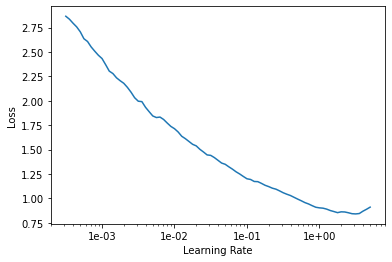

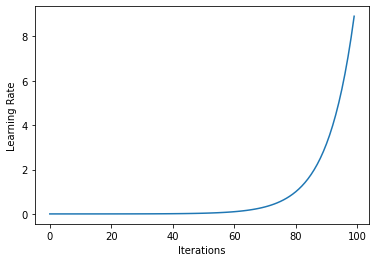

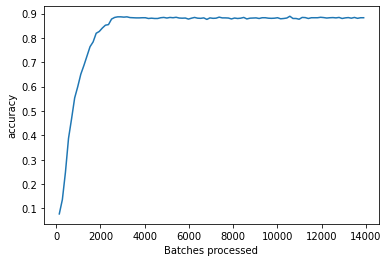

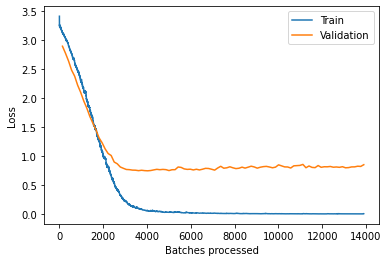

In [35]:
    #TEST 2 - Resnet18 4000 systems def hyperparameters
folder   = 'raw_data_transfering_4000_'
d_type   = d_type_opt[0]
seed     = str(1111)
sys_size = 20

create_learner(folder, d_type, seed, extr=True, batch_size=120)
local_tests[str(c_model+'-max_e=100-'+'lr=1-'+'epoch_chunk=100-')] = [train_max_epochs(100,lr=1, epoch_chunk=100)]

####TEST 3 - Densenet121 4000 systems optimised hyperparameters (Bayesian)

|   iter    |  target   |    lr     |    mom    |    wd     |
-------------------------------------------------------------
Found pre-loaded data raw_data_transfering_200_training_seed1111



----
   Taking only the extreme classes
len labels:      2
len training:    2
len validation:  2
len testing:     2
labels =         ['18.0', '15.0']
----





epoch,train_loss,valid_loss,accuracy,time
0,1.789736,1.442247,0.444444,00:03


Accuracy:44.44444477558136
|  1        |  0.4444   |  4.176    |  0.7131   |  0.000214 |
Found pre-loaded data raw_data_transfering_200_training_seed1111



----
   Taking only the extreme classes
len labels:      2
len training:    2
len validation:  2
len testing:     2
labels =         ['18.0', '15.0']
----





epoch,train_loss,valid_loss,accuracy,time
0,1.757250,1.072803,0.444444,00:03


Accuracy:44.44444477558136
|  2        |  0.4444   |  3.03     |  0.1453   |  0.09243  |
Found pre-loaded data raw_data_transfering_200_training_seed1111



----
   Taking only the extreme classes
len labels:      2
len training:    2
len validation:  2
len testing:     2
labels =         ['18.0', '15.0']
----





epoch,train_loss,valid_loss,accuracy,time
0,1.443812,1.307428,0.444444,00:03


Accuracy:44.44444477558136
|  3        |  0.4444   |  9.995    |  0.603    |  0.9639   |
Found pre-loaded data raw_data_transfering_200_training_seed1111



----
   Taking only the extreme classes
len labels:      2
len training:    2
len validation:  2
len testing:     2
labels =         ['18.0', '15.0']
----





epoch,train_loss,valid_loss,accuracy,time
0,2.823051,2.797831,0.444444,00:03


Accuracy:44.44444477558136
|  4        |  0.4444   |  0.02403  |  0.03857  |  0.1931   |
Found pre-loaded data raw_data_transfering_200_training_seed1111



----
   Taking only the extreme classes
len labels:      2
len training:    2
len validation:  2
len testing:     2
labels =         ['18.0', '15.0']
----





epoch,train_loss,valid_loss,accuracy,time
0,1.512010,1.125738,0.444444,00:03


Accuracy:44.44444477558136
|  5        |  0.4444   |  9.996    |  0.9884   |  0.9916   |
Found pre-loaded data raw_data_transfering_200_training_seed1111



----
   Taking only the extreme classes
len labels:      2
len training:    2
len validation:  2
len testing:     2
labels =         ['18.0', '15.0']
----





epoch,train_loss,valid_loss,accuracy,time
0,2.772453,2.814824,0.222222,00:03


Accuracy:22.22222238779068
|  6        |  0.2222   |  0.0189   |  0.08859  |  0.5048   |
Found pre-loaded data raw_data_transfering_200_training_seed1111



----
   Taking only the extreme classes
len labels:      2
len training:    2
len validation:  2
len testing:     2
labels =         ['18.0', '15.0']
----





epoch,train_loss,valid_loss,accuracy,time
0,1.573440,1.092884,0.444444,00:03


Accuracy:44.44444477558136
|  7        |  0.4444   |  7.267    |  0.0      |  0.0001   |
Iteration 0: 
	{'target': 0.4444444477558136, 'params': {'lr': 4.176049826978714, 'mom': 0.7131212485077365, 'wd': 0.00021436337986315216}}
Iteration 1: 
	{'target': 0.4444444477558136, 'params': {'lr': 3.0303024005920793, 'mom': 0.14528833190894191, 'wd': 0.09242936090932093}}
Iteration 2: 
	{'target': 0.4444444477558136, 'params': {'lr': 9.994907470166536, 'mom': 0.6030195403462183, 'wd': 0.9639363225833915}}
Iteration 3: 
	{'target': 0.4444444477558136, 'params': {'lr': 0.024025680336417, 'mom': 0.038569443073310644, 'wd': 0.19309903551955998}}
Iteration 4: 
	{'target': 0.4444444477558136, 'params': {'lr': 9.996347945075506, 'mom': 0.9884278864960957, 'wd': 0.9915658322715345}}
Iteration 5: 
	{'target': 0.2222222238779068, 'params': {'lr': 0.018902601788937698, 'mom': 0.08859200705091115, 'wd': 0.5047570054903805}}
Iteration 6: 
	{'target': 0.4444444477558136, 'params': {'lr': 7.267408290812069,

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
mkdir: cannot create directory ‘/content/drive/MyDrive/ModelStages/CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=40-ntrain=raw_data_transfering_200_training_1111’: File exists


NameError: ignored

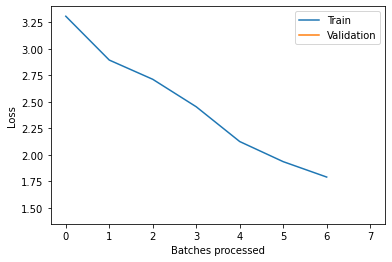

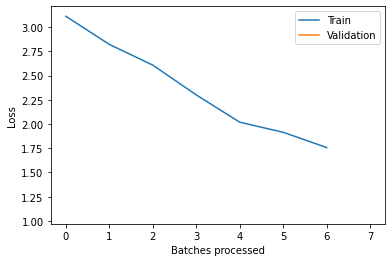

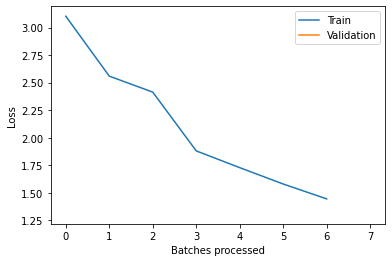

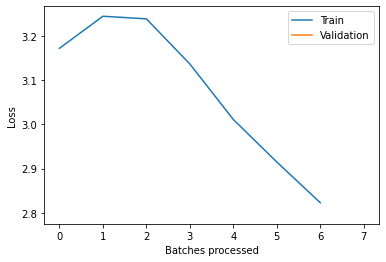

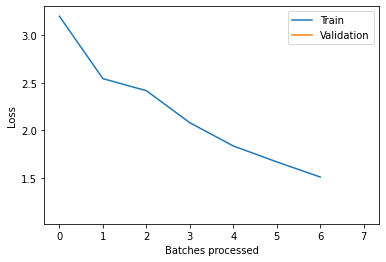

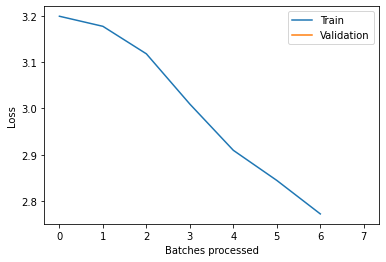

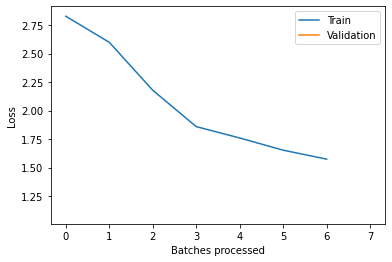

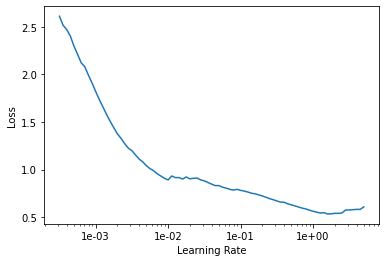

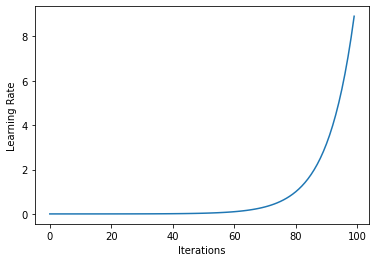

In [93]:
    #TEST 3 - Densenet 4000 systems optimised hyperparameters (Bayesian)
def fit_with_1(lr, mom, wd):
  folder = 'raw_data_transfering_200_'
  d_type = d_type_opt[0]
  seed = str(1111)
  batch_size = 120
  databunch = prepare_datasets(folder, d_type, seed, batch_size=batch_size, binning=False, bin_size=3, skip_amount=0, extr=True)

  learn = cnn_learner(databunch, models.densenet121, metrics=[accuracy], loss_func=torch.nn.CrossEntropyLoss(), opt_func=optim.SGD, pretrained=False)
  learn.model[0][0] = nn.Conv2d(20, 1024, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  learn.model[1][8] = nn.Linear(in_features=512, out_features=n_labels, bias=True)

  learn.fit_one_cycle(1, max_lr=lr)
  learn.recorder.plot_losses()
  acc = float(learn.validate(learn.data.valid_dl)[1])

  print("Accuracy:" + str(acc*100))
  return acc

pbounds = {'lr': (1e-2, 1e+1), 'mom':(0, 0.99), 'wd':(1e-4, 1)}
result = optimise_bayesian(pbounds, fit_with_1)

print("result:", result)

folder   = 'raw_data_transfering_200_'
d_type   = d_type_opt[0]
seed     = str(1111)
sys_size = 20

create_learner(folder, d_type, seed, extr=True, batch_size=120)
local_tests[str(c_model+'-max_e=100-'+'lr=1-'+'epoch_chunk=100-')] = [train_with_parameters(100,lr=best_lr,mom=best_mom, weight_decay=best_weight_decay, epoch_chunk=100)]

####TEST 4 - Create Custom Learner experiment

In [ ]:
create_custom_learner(folder, d_type, seed)
train_max_epochs(1, 0.1, 0.1, 0.1, 1, save = False)

####TEST 5 - Skipping classes test 

In [ ]:
results = {}

def get_losses_bin_skip(bin_size,skip_amount):
  create_learner(folder,d_type,seed, show_model=False, batch_size=30, binning=True,bin_size=bin_size, skip_amount=skip_amount, save=True)
  epoch_goal = 10
  lr = 1
  mom = 0
  wd = 1
  epoch_chunk = 10
  training_losses,validation_losses = train_max_epochs(epoch_goal,lr,mom,wd,epoch_chunk,save=False)
  results[str(bin_size)+str(skip_amount)] = [training_losses,validation_losses]
  print(results)
get_losses_bin_skip(1,0)
get_losses_bin_skip(1,1)
get_losses_bin_skip(1,2)
get_losses_bin_skip(1,3)
get_losses_bin_skip(1,4)

In [ ]:
import matplotlib.pyplot as plt

print(results['11'][0])

plt.plot(range(len(results['11'][0])), results['11'][0], '-b')
plt.plot(range(len(results['12'][0])), results['12'][0], '-b')
plt.plot(range(len(results['13'][0])), results['13'][0], '-b')
plt.plot(range(len(results['14'][0])), results['14'][0], '-b')

plt.plot(range(len(results['11'][0])), results['11'][1], '-r')
plt.plot(range(len(results['12'][0])), results['12'][1], '-r')
plt.plot(range(len(results['13'][0])), results['13'][1], '-r')
plt.plot(range(len(results['14'][0])), results['14'][1], '-r')

plt.title("Train and Valid Losses for different skipping values")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()

####TEST 6 - resnet18 4000 systems sys_size=30 default hyperparameters

In [94]:
    #TEST 2 - Resnet18 4000 systems def hyperparameters
folder   = 'raw_data_transfering_1000_30_'
d_type   = d_type_opt[0]
seed     = str(1111)
sys_size = 30

create_learner(folder, d_type, seed, extr=True, batch_size=120)
local_tests[str(c_model+'-max_e=100-'+'lr=1-'+'epoch_chunk=100-')] = [train_max_epochs(100,lr=1, epoch_chunk=100)]

   Data directory:  /content/drive/MyDrive/csvdata/raw_data_transfering_1000_30_training_seed1111/
Number of classes:  17
W18.0-1000data_seed1111.csv


IndexError: ignored

# Interpretation

In [ ]:
def show_confs(c_model):
  dir = '/content/drive/MyDrive/ModelStages/'+c_model
  epochs = !ls -l {dir}
  epochs.reverse()
  epochs.pop()

  max_epoch_value = 0
  for i in range(len(epochs)):
    epochs[i] = epochs[i].rsplit(' ',1)[1]
    epochs[i] = epochs[i].rsplit('.',1)[0]
  print(epochs)

  for epoch in epochs:
    learn.load('/content/drive/MyDrive/ModelStages/'+c_model+'/'+epoch);
    preds,y,losses = learn.get_preds(with_loss=True)
    interp = ClassificationInterpretation(learn,preds,y,losses)
    interp.plot_confusion_matrix(figsize=(7,7))

In [ ]:
#show_confs(c_model)

#learn.load('/content/drive/MyDrive/ModelStages/'+c_model+'/epochs-10');
learn.load('/content/drive/MyDrive/ModelStages/'+'CONV2D-resnet18_error_rate_loss=default'+'/epochs-210');
preds,y,losses = learn.get_preds(with_loss=True)
interp = ClassificationInterpretation(learn,preds,y,losses)
interp.plot_confusion_matrix(figsize=(7,7))

##General Testing Area

In [ ]:
folder = 'raw_data_transfering_200_'
d_type = d_type_opt[0]

create_learner(folder, d_type, save=False)

preds,targs = learn.get_preds()
print(targs)
print(preds)
print(len(preds))

learn.pred_batch()

#Hyperparameter Optimisation Test area

##Our own grid search algorithm

In [ ]:
parameter_lims = {}
parameter_lims['bs']  = [20,30,40]
parameter_lims['opt'] = [optim.Adam,optim.AdamW]
parameter_lims['mom'] = [0,0.5,0.9]
lr = 0.1

for bs_val in parameter_lims['bs']:
  for opt_val in parameter_lims['opt']:
    for mom_val in parameter_lims['mom']:
      train_losses,valid_losses = train_with_parameters(1,bs_val, opt_val, mom_val, 0, lr)
      print("parameters: bs_val=", bs_val, " opt=", opt_val, " mom=", mom_val)
      print("train_loss=", train_losses[-1])
      print("valid_loss=", valid_losses[-1])

##Online grid search

In [1]:
from sklearn.model_selection import GridSearchCV
from torch import nn
import numpy as np
from sklearn.datasets import make_classification
!pip install --user skorch
from skorch import NeuralNetClassifier

class MyModule(nn.Module):
    def __init__(self, num_units=10, nonlin=nn.ReLU()):
        super(MyModule, self).__init__()

        self.dense0 = nn.Linear(20, num_units)
        self.nonlin = nonlin
        self.dropout = nn.Dropout(0.5)
        self.dense1 = nn.Linear(num_units, num_units)
        self.output = nn.Linear(num_units, 2)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, X, **kwargs):
        X = self.nonlin(self.dense0(X))
        X = self.dropout(X)
        X = self.nonlin(self.dense1(X))
        X = self.softmax(self.output(X))
        return X


net = NeuralNetClassifier(
    MyModule,
    max_epochs=10,
    lr=0.1,
    # Shuffle training data on each epoch
    iterator_train__shuffle=True,
)


net.set_params(train_split=False, verbose=0)
params = {
    'lr': [0.01, 0.02],
    'max_epochs': [10, 20],
    'module__num_units': [10, 20],
}


X, y = make_classification(1000, 20, n_informative=10, random_state=0)
X = X.astype(np.float32)
y = y.astype(np.int64)

gs = GridSearchCV(net, params, refit=False, cv=3, scoring='accuracy', verbose=2)
gs.fit(X, y)
print("best score: {:.3f}, best params: {}".format(gs.best_score_, gs.best_params_))

     |████████████████████████████████| 133kB 6.7MB/s 
ERROR: Operation cancelled by user


ModuleNotFoundError: ignored